### **This Notebook Detects Representative Spectra within each Surface**

This is done by building a similarity graph between each spectra, based on the Gaussian Kernel, then detecting the most representative spectra within each surface based on the PageRank centrality.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [3]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [4]:
#sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [5]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


In [6]:
pivoted_df = df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
pivoted_df.columns.name = None

statuses = df[['SpecID', 'Status']].drop_duplicates()

pivoted_df = pd.merge(pivoted_df, statuses, on='SpecID')
pivoted_df = pivoted_df.set_index('SpecID')

pivoted_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,6.942749,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,Normal
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,6.322524,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,Normal
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,-4.668874,-4.633601,-4.557349,-4.439365,-4.278894,-4.075180,-3.827470,-3.535010,-3.197043,Normal
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,-11.220152,-10.801936,-10.349539,-9.864191,-9.347124,-8.799567,-8.222752,-7.617909,-6.986269,Normal
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,-11.600625,-11.689508,-11.752441,-11.789205,-11.799583,-11.783357,-11.740310,-11.670224,-11.572882,Normal


In [7]:
status_df = df.groupby('SpecID')[['SurID', 'Status']].first()
# surface_and_status.to_csv("../../data/surface_and_status.csv")
status_df

,SurID,Status
SpecID,,
201210-1-00,201210-1,Normal
201210-1-01,201210-1,Normal
201210-1-02,201210-1,Normal
201210-1-03,201210-1,Normal
201210-1-04,201210-1,Normal
...,...,...
210526-3-45,210526-3,Hyperglycemia
210526-3-46,210526-3,Hyperglycemia
210526-3-47,210526-3,Hyperglycemia


>#### **Calculate an adjacency matrix using a Gaussian Kernel**

In [8]:
pivoted_df.reset_index(inplace=True)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

features_df = pivoted_df.drop(columns=['Status', 'SpecID'])

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(features_df)

# If you want to convert it to a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=pivoted_df['SpecID'], columns=pivoted_df['SpecID'])

In [10]:
kernel_df = cosine_sim_df

**Construct the node and edge import files with the required Admin Import Headers**

In [11]:
relationship_df = kernel_df.reset_index()
relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
relationship_df[':TYPE'] = 'LINK'

Drop Relationships a node has with itself, along with repeat relationships.

In [12]:
relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]  # Drops redundant relationships
relationship_df

,:START_ID,:END_ID,Weight:float,:TYPE
3045,201210-1-00,201210-1-01,0.957324,LINK
6090,201210-1-00,201210-1-02,0.653678,LINK
6091,201210-1-01,201210-1-02,0.705184,LINK
9135,201210-1-00,201210-1-03,0.657468,LINK
9136,201210-1-01,201210-1-03,0.671162,LINK
...,...,...,...,...
9272019,210526-3-44,210526-3-49,0.985379,LINK
9272020,210526-3-45,210526-3-49,0.981424,LINK
9272021,210526-3-46,210526-3-49,0.985845,LINK
9272022,210526-3-47,210526-3-49,0.979058,LINK


In [13]:
node_df = status_df.reset_index()
node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL', 'SurID':'SurID:LABEL'}, inplace=True)
node_df

,SpecID:ID,SurID:LABEL,Status:LABEL
0,201210-1-00,201210-1,Normal
1,201210-1-01,201210-1,Normal
2,201210-1-02,201210-1,Normal
3,201210-1-03,201210-1,Normal
4,201210-1-04,201210-1,Normal
...,...,...,...
3040,210526-3-45,210526-3,Hyperglycemia
3041,210526-3-46,210526-3,Hyperglycemia
3042,210526-3-47,210526-3,Hyperglycemia
3043,210526-3-48,210526-3,Hyperglycemia


In [14]:
node_df.to_csv(f"{neo4j_directory}/import/nodes.csv", index=False)

In [15]:
relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [16]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

---

### **Neo4J Queries**

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [17]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data/databases/neo4j:\nNodes:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/nodes.csv\n\nRelationships:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 15.47GiB\n  Free machine memory: 5.632GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 8\n  Configured max memory: 4.289GiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\nImport s

In [18]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j......... stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9f

Run and connect to the Neo4j Database

In [19]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**We will calculate the centrality rank of each spectra within it's surface**

In [20]:
surfaces = status_df['SurID'].unique()
surfaces

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210407-1',
       '210407-2', '210414-1', '210414-2', '210414-3', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

In [21]:
pagerank_dfs = []

def project_graph(tx, surface):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      $nodeLabel,
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query, nodeLabel=surface)

def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

for surface in surfaces:
    with driver.session() as session:
        session.execute_write(project_graph, surface)
        pagerank_results = session.execute_read(run_pagerank_centrality)
        pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
        pagerank_df['SurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense', ascending=False)  # Get the rank of centrality of each spectra within the surface
        pagerank_df['ReverseSurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense')  # Get the rank of centrality of each spectra within the surface
        pagerank_dfs.append(pagerank_df)
        session.execute_write(delete_projection)


Unable to retrieve routing information
Transaction failed and will be retried in 0.8154001265098505s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 2.051730124372712s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 3.313728183360948s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 9.125108519514448s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 17.73995854037926s (Unable to retrieve routing information)


In [22]:
close_driver()

In [23]:
pagerank_results = pd.concat(pagerank_dfs).rename(columns={'name':'SpecID'})
pagerank_results

,SpecID,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-39,1.002601,1.0,49.0
1,201210-1-47,0.999744,2.0,48.0
2,201210-1-49,0.999009,3.0,47.0
3,201210-1-43,0.997339,4.0,46.0
4,201210-1-46,0.997122,5.0,45.0
...,...,...,...,...
45,210526-3-06,0.915257,46.0,5.0
46,210526-3-04,0.907936,47.0,4.0
47,210526-3-01,0.815994,48.0,3.0
48,210526-3-32,0.806690,49.0,2.0


##### **Test how different Centrality Ranks affect Predictive Performance**

In [24]:
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import ExtraTreesClassifier

In [25]:
df = df.merge(pagerank_results, on='SpecID')
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303,0.964108,35.0,15.0
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843,0.964108,35.0,15.0
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884,0.964108,35.0,15.0
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722,0.964108,35.0,15.0
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654,0.964108,35.0,15.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163,0.978026,26.0,25.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937,0.978026,26.0,25.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285,0.978026,26.0,25.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531,0.978026,26.0,25.0


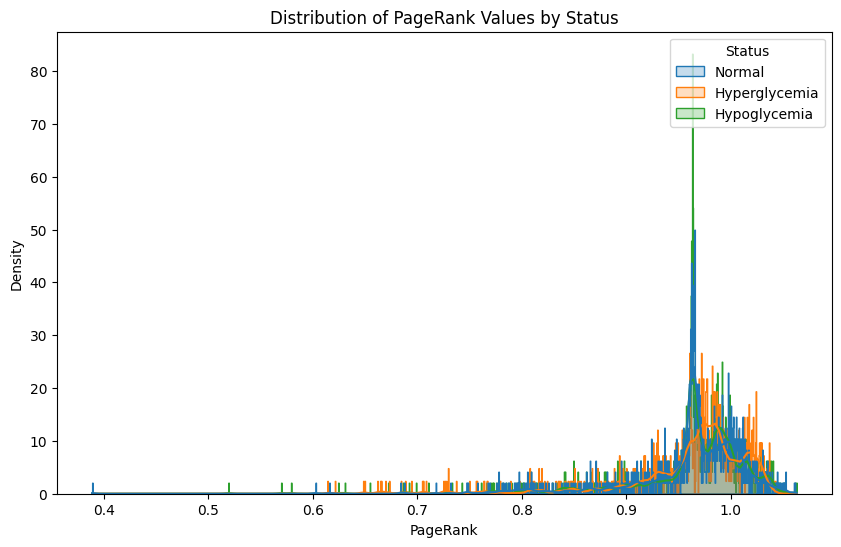

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="PageRank", hue="Status", kde=True, element="step", stat="density", common_norm=False)
plt.title('Distribution of PageRank Values by Status')
plt.xlabel('PageRank')
plt.ylabel('Density')
plt.show()

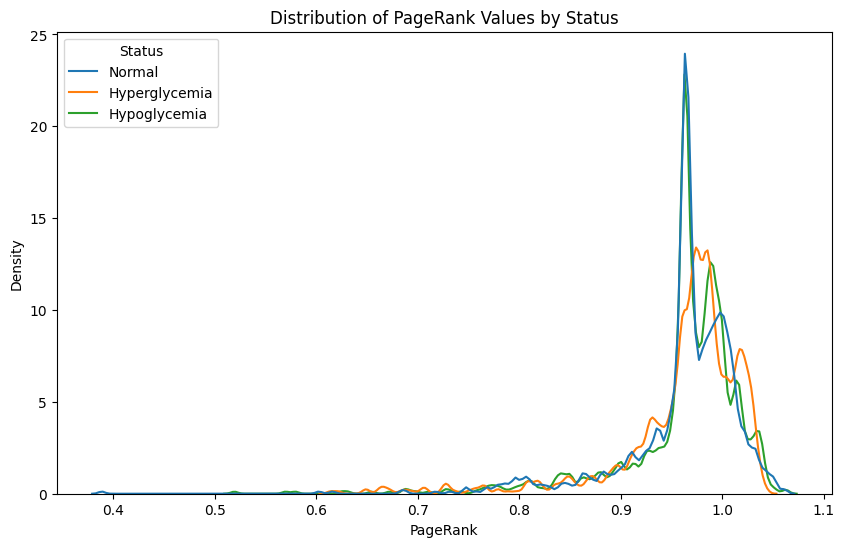

In [27]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="PageRank", hue="Status", common_norm=False)
plt.title('Distribution of PageRank Values by Status')
plt.xlabel('PageRank')
plt.ylabel('Density')
plt.show()

In [48]:
from scipy.stats import gaussian_kde

# Aggregating PageRank values by SurID
page_ranks_by_surid = df.groupby('SurID')['PageRank'].apply(list).to_dict()

# Define the range and number of points for vectorization
min_page_rank = df['PageRank'].min()
max_page_rank = df['PageRank'].max()
num_points = 1000  # Number of points in the vector
x = np.linspace(min_page_rank, max_page_rank, num_points)

# Vectorization: compute KDE for each SurID and evaluate it on the fixed set of points
vectors = {}
for surid, page_ranks in page_ranks_by_surid.items():
    kde = gaussian_kde(page_ranks)
    density = kde(x)
    vectors[surid] = density

# Displaying the vector for the first SurID as an example
example_surid = list(vectors.keys())[0]
example_vector = vectors[example_surid]

In [49]:
kde_pagerank_df = pd.DataFrame(vectors)

In [50]:
kde_pagerank_df = pd.DataFrame(vectors).transpose()
kde_pagerank_df.reset_index(inplace=True)
kde_pagerank_df.rename(columns={'index': 'SurID'}, inplace=True)

In [51]:
kde_pagerank_df = pd.merge(kde_pagerank_df, status_df, how='left', on='SurID')

In [52]:
kde_pagerank_df

,SurID,0,1,2,3,4,5,6,7,8,...,991,992,993,994,995,996,997,998,999,Status
0,201210-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.955678e-19,2.100382e-19,7.314493e-20,2.515289e-20,8.540987e-21,2.863808e-21,9.481872e-22,3.099973e-22,1.000770e-22,Normal
1,201210-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.955678e-19,2.100382e-19,7.314493e-20,2.515289e-20,8.540987e-21,2.863808e-21,9.481872e-22,3.099973e-22,1.000770e-22,Normal
2,201210-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.955678e-19,2.100382e-19,7.314493e-20,2.515289e-20,8.540987e-21,2.863808e-21,9.481872e-22,3.099973e-22,1.000770e-22,Normal
3,201210-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.955678e-19,2.100382e-19,7.314493e-20,2.515289e-20,8.540987e-21,2.863808e-21,9.481872e-22,3.099973e-22,1.000770e-22,Normal
4,201210-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.955678e-19,2.100382e-19,7.314493e-20,2.515289e-20,8.540987e-21,2.863808e-21,9.481872e-22,3.099973e-22,1.000770e-22,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.950088e-43,4.093706e-44,5.570992e-45,7.435016e-46,9.731144e-47,1.249044e-47,1.572254e-48,1.940878e-49,2.349652e-50,Hyperglycemia
3041,210526-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.950088e-43,4.093706e-44,5.570992e-45,7.435016e-46,9.731144e-47,1.249044e-47,1.572254e-48,1.940878e-49,2.349652e-50,Hyperglycemia
3042,210526-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.950088e-43,4.093706e-44,5.570992e-45,7.435016e-46,9.731144e-47,1.249044e-47,1.572254e-48,1.940878e-49,2.349652e-50,Hyperglycemia
3043,210526-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.950088e-43,4.093706e-44,5.570992e-45,7.435016e-46,9.731144e-47,1.249044e-47,1.572254e-48,1.940878e-49,2.349652e-50,Hyperglycemia


In [53]:
evaluate_extra_trees(kde_pagerank_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.2956 +/- 0.1776
ExtraTreesClassifier Cross-Validation Precision: 0.2306 +/- 0.1775
ExtraTreesClassifier Cross-Validation Recall: 0.2910 +/- 0.1528
ExtraTreesClassifier Cross-Validation F1-Score: 0.2230 +/- 0.1333


In [40]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [39]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [33]:
def compare_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    return np.mean(scores['test_accuracy'])

In [34]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [35]:
wavelength_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,201210-1,Normal
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,201210-1,Normal
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,-4.633601,-4.557349,-4.439365,-4.278894,-4.075180,-3.827470,-3.535010,-3.197043,201210-1,Normal
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,-10.801936,-10.349539,-9.864191,-9.347124,-8.799567,-8.222752,-7.617909,-6.986269,201210-1,Normal
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,-11.689508,-11.752441,-11.789205,-11.799583,-11.783357,-11.740310,-11.670224,-11.572882,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,11.003178,12.008451,12.879986,13.624553,14.248922,14.759862,15.164145,15.468539,15.679816,15.804744,...,6.671003,7.197072,7.711103,8.211164,8.695324,9.161650,9.608210,10.033072,210526-3,Hyperglycemia
210526-3-46,14.239653,13.596345,12.981340,12.396227,11.842591,11.322020,10.836101,10.386421,9.974566,9.602123,...,2.124074,2.718437,3.405898,4.190762,5.077335,6.069920,7.172824,8.390352,210526-3,Hyperglycemia
210526-3-47,17.165901,17.349777,17.457499,17.494696,17.466999,17.380039,17.239446,17.050852,16.819887,16.552181,...,6.895403,7.740965,8.633346,9.572405,10.558000,11.589990,12.668233,13.792588,210526-3,Hyperglycemia


In [36]:
evaluate_extra_trees(wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6123 +/- 0.1083
ExtraTreesClassifier Cross-Validation Precision: 0.6069 +/- 0.1072
ExtraTreesClassifier Cross-Validation Recall: 0.6205 +/- 0.1331
ExtraTreesClassifier Cross-Validation F1-Score: 0.5935 +/- 0.1231


#### **Only keep the top k most central spectra**

In [37]:
representative_df = df[df['SurfacePageRankRank'] <= 40]
representative_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303,0.964108,35.0,15.0
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843,0.964108,35.0,15.0
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884,0.964108,35.0,15.0
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722,0.964108,35.0,15.0
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654,0.964108,35.0,15.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163,0.978026,26.0,25.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937,0.978026,26.0,25.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285,0.978026,26.0,25.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531,0.978026,26.0,25.0


In [38]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_extra_trees(representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6209 +/- 0.0997
ExtraTreesClassifier Cross-Validation Precision: 0.6001 +/- 0.1048
ExtraTreesClassifier Cross-Validation Recall: 0.6186 +/- 0.1377
ExtraTreesClassifier Cross-Validation F1-Score: 0.5835 +/- 0.1160


#### **Alternatively, try dropping the least central spectra from each Surface**

In [39]:
representative_df = df[df['ReverseSurfacePageRankRank'] >= 5]
representative_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303,0.964108,35.0,15.0
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843,0.964108,35.0,15.0
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884,0.964108,35.0,15.0
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722,0.964108,35.0,15.0
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654,0.964108,35.0,15.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163,0.978026,26.0,25.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937,0.978026,26.0,25.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285,0.978026,26.0,25.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531,0.978026,26.0,25.0


In [40]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_extra_trees(representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6174 +/- 0.1036
ExtraTreesClassifier Cross-Validation Precision: 0.6153 +/- 0.1036
ExtraTreesClassifier Cross-Validation Recall: 0.6276 +/- 0.1297
ExtraTreesClassifier Cross-Validation F1-Score: 0.5991 +/- 0.1190


In [90]:
aggregated_df = df.groupby('SurID')['PageRank'].agg(
    Mean='mean',
    STD='std',
    Median='median',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

In [94]:
pagerank_stats = df.groupby(['SpecID', 'SurID', 'Status'])['PageRank'].first().reset_index()

In [96]:
pagerank_stats = pd.merge(pagerank_stats, aggregated_df, how='left', on='SurID')

In [98]:
# Adding a new column for the difference from mean
pagerank_stats["Difference from Mean"] = pagerank_stats["Mean"] - pagerank_stats["PageRank"]

# Adding a new column for IQR (Interquartile Range)
pagerank_stats["IQR"] = pagerank_stats["Q3"] - pagerank_stats["Q1"]

In [91]:
aggregated_df

,SurID,Mean,STD,Median,Q1,Q3
0,201210-1,0.96124,0.060023,0.982386,0.954417,0.990545
1,201210-2,0.96124,0.069386,0.996611,0.947688,1.005951
2,210114-1,0.96124,0.070386,0.999411,0.952701,1.004599
3,210114-2,0.96124,0.064764,0.987306,0.920427,1.016745
4,210120-1,0.96124,0.064548,0.984234,0.931165,1.007261
...,...,...,...,...,...,...
58,210519-3,0.96124,0.039343,0.976085,0.951688,0.987482
59,210524-1,0.96124,0.022217,0.973444,0.932037,0.976517
60,210526-1,0.96124,0.027295,0.974289,0.947135,0.982373
61,210526-2,0.96124,0.000711,0.961134,0.960626,0.961959


In [42]:
# Step 1: Calculate the 50th percentile of SurfacePageRankRank for each SurID
median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.8))

# Step 2: Keep only the rows with SurfacePageRankRank >= to its group's median
filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]
opposite_df = df[df['SurfacePageRankRank'] >= median_ranks]

In [43]:
fil_sample = filtered_df[filtered_df['SurID'] == '201210-1']
opp_sample = opposite_df[opposite_df['SurID'] == '201210-1']

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

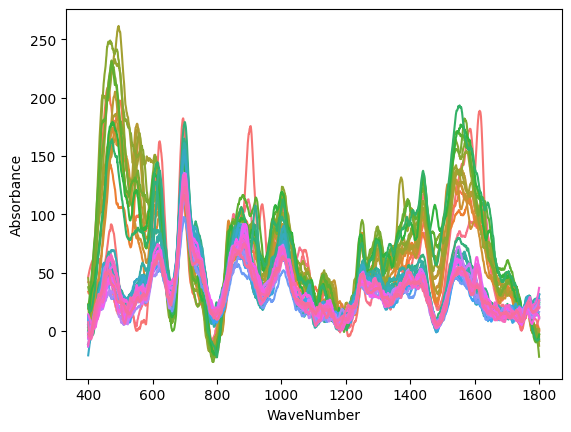

In [44]:
sns.lineplot(data=fil_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

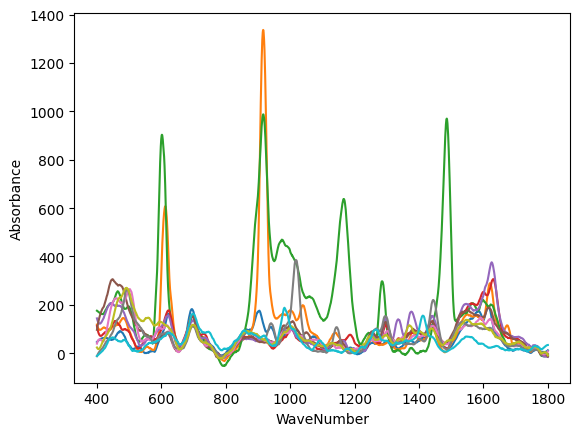

In [45]:
sns.lineplot(data=opp_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

In [46]:
filtered_representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
evaluate_extra_trees(filtered_representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6119 +/- 0.0790
ExtraTreesClassifier Cross-Validation Precision: 0.6108 +/- 0.0836
ExtraTreesClassifier Cross-Validation Recall: 0.6278 +/- 0.1054
ExtraTreesClassifier Cross-Validation F1-Score: 0.5797 +/- 0.0906


In [62]:
percentage = []
acurate = []

for num in np.arange(0.7, 0.86, 0.02):
    median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(num))
    filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]
    filtered_representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
    accuracy = compare_extra_trees(filtered_representative_wavelength_df)
    percentage.append(num)
    acurate.append(accuracy)

test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/s

In [63]:
test_results

,Percentage Cutoff,Accuracy
0,0.70,0.575778
1,0.72,0.567786
2,0.74,0.568304
3,0.76,0.574306
4,0.78,0.570022
5,0.80,0.582188
6,0.82,0.582075
7,0.84,0.565264
8,0.86,0.571059


<Axes: xlabel='Percentage Cutoff', ylabel='Accuracy'>

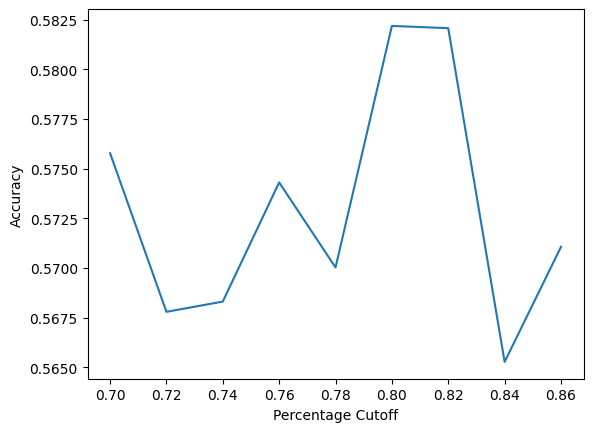

In [64]:
sns.lineplot(data=test_results, y='Accuracy', x='Percentage Cutoff')

## PageRank Cutofff

In [154]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,0.241429,0.943418,26.0,24.0
1,201210-1-00,294,400.91116,201210-1,Normal,0.241086,0.943418,26.0,24.0
2,201210-1-00,295,401.59454,201210-1,Normal,0.240729,0.943418,26.0,24.0
3,201210-1-00,296,402.27789,201210-1,Normal,0.240359,0.943418,26.0,24.0
4,201210-1-00,297,402.96127,201210-1,Normal,0.239978,0.943418,26.0,24.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,0.060284,0.999562,25.0,26.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,0.064627,0.999562,25.0,26.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,0.069153,0.999562,25.0,26.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,0.073864,0.999562,25.0,26.0


In [76]:
PageRank_filter = df[df['PageRank'] > 0.96]
opp_PageRank_filter = df[df['PageRank'] <= 0.96]

In [77]:
PageRank_filter

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303,0.964108,35.0,15.0
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843,0.964108,35.0,15.0
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884,0.964108,35.0,15.0
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722,0.964108,35.0,15.0
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654,0.964108,35.0,15.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163,0.978026,26.0,25.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937,0.978026,26.0,25.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285,0.978026,26.0,25.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531,0.978026,26.0,25.0


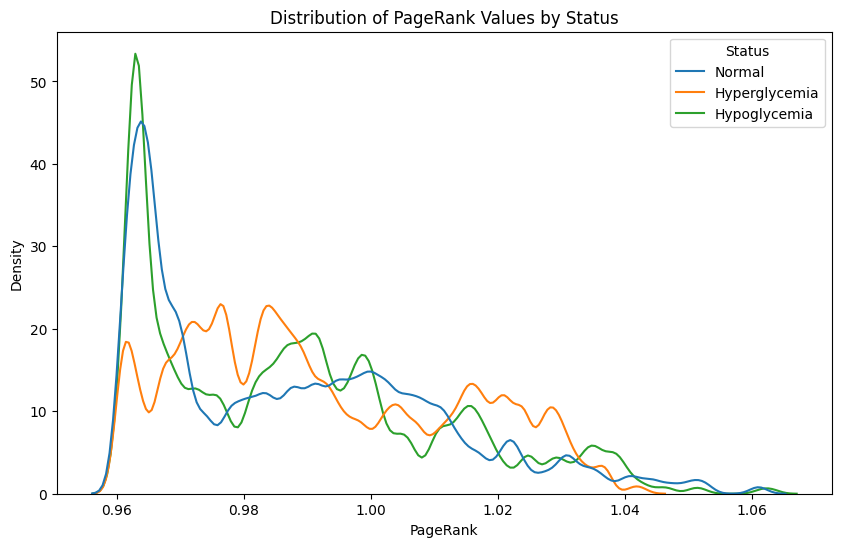

In [79]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=PageRank_filter, x="PageRank", hue="Status", common_norm=False)
plt.title('Distribution of PageRank Values by Status')
plt.xlabel('PageRank')
plt.ylabel('Density')
plt.show()

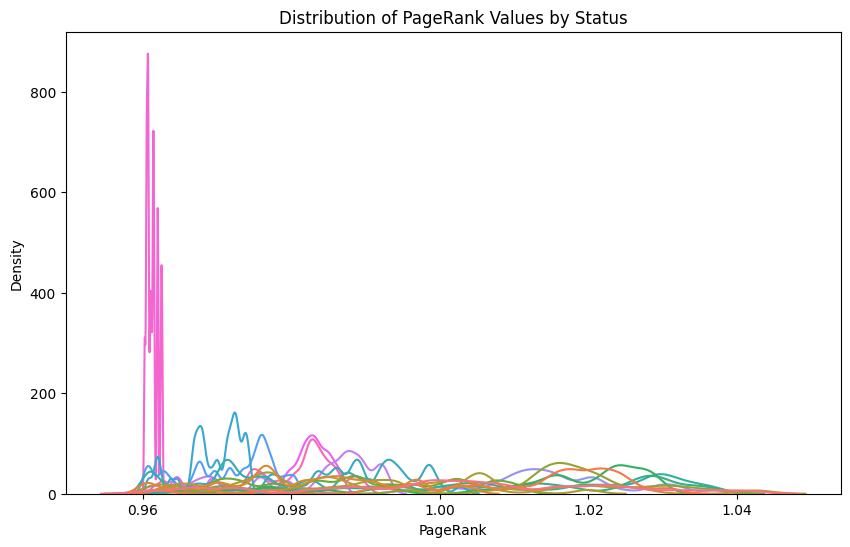

In [82]:
Normal_df = PageRank_filter[PageRank_filter['Status'] == 'Hyperglycemia']

plt.figure(figsize=(10, 6))
sns.kdeplot(data=Normal_df, x="PageRank", hue="SurID", common_norm=False, legend=False)
plt.title('Distribution of PageRank Values by Status')
plt.xlabel('PageRank')
plt.ylabel('Density')
plt.show()

In [64]:
fil_sample = PageRank_filter[PageRank_filter['SurID'] == '201210-1']
opp_sample = opp_PageRank_filter[opp_PageRank_filter['SurID'] == '201210-1']

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

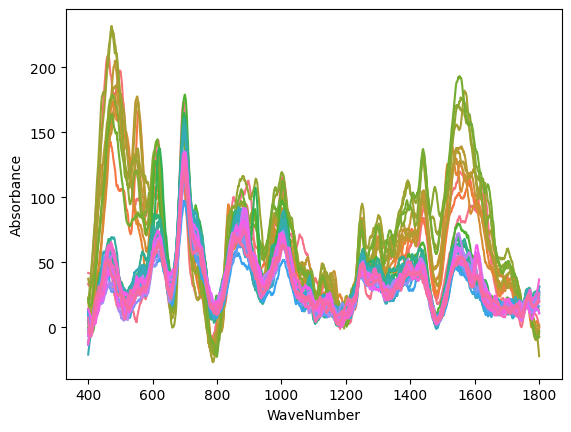

In [65]:
sns.lineplot(data=fil_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

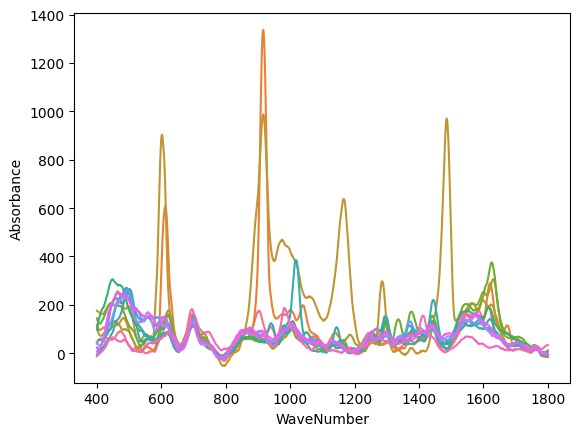

In [66]:
sns.lineplot(data=opp_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

In [67]:
PageRank_filter.shape

(4384860, 9)

In [68]:
PageRank_filter.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia    625
Hypoglycemia     768
Normal           747
Name: SpecID, dtype: int64

In [69]:
filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
evaluate_extra_trees(filtered_representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6060 +/- 0.0921
ExtraTreesClassifier Cross-Validation Precision: 0.5573 +/- 0.1094
ExtraTreesClassifier Cross-Validation Recall: 0.5519 +/- 0.1514
ExtraTreesClassifier Cross-Validation F1-Score: 0.5300 +/- 0.1199


In [62]:
filtered_representative_wavelength_df.shape

(2669, 2051)

In [70]:
percentage = []
acurate = []

for num in np.arange(0.8, 0.86, 0.005):
    PageRank_filter = df[df['PageRank'] > num]
    filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
    accuracy = compare_extra_trees(filtered_representative_wavelength_df)
    percentage.append(num)
    acurate.append(accuracy)

test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/s

In [71]:
test_results

,Percentage Cutoff,Accuracy
0,0.820,0.639959
1,0.825,0.643536
2,0.830,0.650347
3,0.835,0.632562
4,0.840,0.631084
5,0.845,0.637170
6,0.850,0.641630
7,0.855,0.640855
8,0.860,0.654697


<Axes: xlabel='Percentage Cutoff', ylabel='Accuracy'>

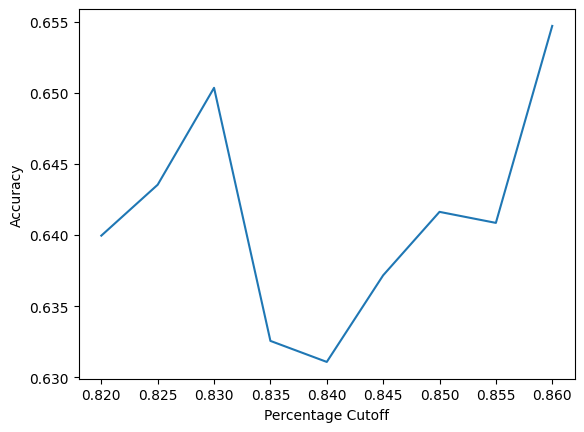

In [72]:
sns.lineplot(data=test_results, y='Accuracy', x='Percentage Cutoff')